# Generalized Hodgkin-Huxley of an intrinsically bursting neuron

Here, the propagation of an "action potential", a spike of activity, along an axon (the part of a neuron along which the signal travels) is studied using the Hodgkin-Huxley model which has governing equation:

$$ C_{M} \frac{\partial V}{\partial t} = \frac{a}{2r_{L}}\frac{\partial^{2}V}{\partial x^{2}} + \sum_{j} \mathbf{I}_{j} $$

where $C_{M}$ is the membrane capacitance, $r_{L}$ is the resistivity inside the cell, and $I_{j}$ are ionic currents for each ion (e.g. Na, Ca, K, SI,). Here, 10 currents are considered, and the entire axon is considered spatially uniform, which means the equation describing the time-evolution of the membrane voltage due to external stimulation $I_{stim}$ is now:

$$ C_{M} \dot{V} = - \sum_{j} \mathbf{I}_{j} + I_{stim} $$

Here again, the data generating code written by Callaham is used. This matlab code numerically integrates the system of ODE's describe in in pages 2121-2123 of the Canavier, Clark and Byrne (1991) [paper](https://journals.physiology.org/doi/abs/10.1152/jn.1991.66.6.2107).

Generated by this code are the following variables:
- V, the membrane voltage (in mV)
- t (time), in ms
- The ionic currents: $I_{Ca}$ (ICa), $I_{CaP}$ (ICaP), $I_{SI}$ (IISI), $I_{K}$ (IK), $I_{L}$(IL), $I_{R}$ (IR), $I_{NS}$ (INS), $I_{Na}$ (INa), $I_{NaCa}$ (INaCa), $I_{NaK}$ (INaK), also in mV
- dV, which is calculated as the negative of the sum of the above currents, divided by Cm, or looking at the equation above is the $\dot{V}$ term.

In [37]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
import sklearn as sk
import sys

sys.path.insert(0, "../Tools/")
import plot_funcs as pf

## 1. Load the data

In [11]:
# Load the data
data = sio.loadmat("../Data/burst_data.mat")

# Load the variables
V = data["V"]
t = data["time"]
I_Ca = data["ICa"]
I_CaP = data["ICaP"]
I_SI = data["IISI"]
I_K = data["IK"]
I_L = data["IL"]
I_R = data["IR"]
I_NS = data["INS"]
I_Na = data["INa"]
I_NaCa = data["INaCa"]
I_NaK = data["INaK"]
V_dot = data["dV"]
C_M = data["Cm"]

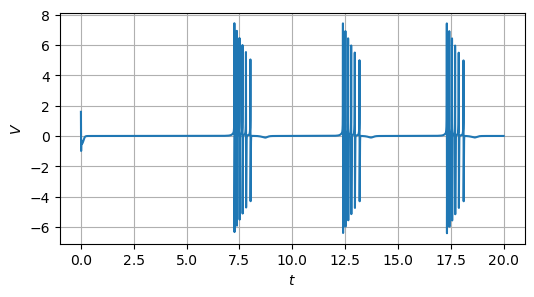

In [12]:
plt.figure(figsize=(6, 3))
plt.plot(t, V_dot)

plt.xlabel("$t$")
plt.ylabel(r"$V$")
plt.grid()

plt.gca().set_axisbelow(True)
plt.show()

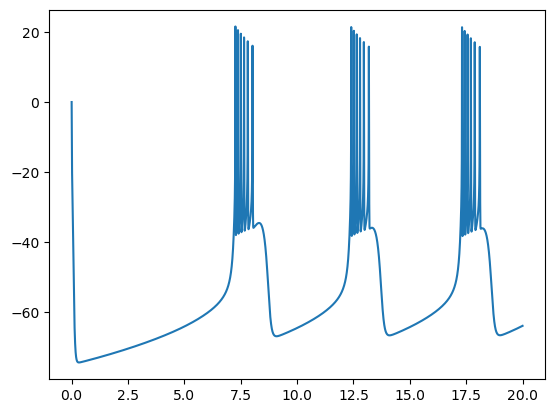

In [13]:
plt.plot(t, V)

## 2. Get the features

In [29]:
features = pd.DataFrame(
    {
        "RHS": C_mV_dot.flatten(),
        "I_Ca": I_Ca.flatten(),
        "I_CaP": I_CaP.flatten(),
        "I_SI": I_SI.flatten(),
        "I_K": I_K.flatten(),
        "I_L": I_L.flatten(),
        "I_R": I_R.flatten(),
        "I_NS": I_NS.flatten(),
        "I_Na": I_Na.flatten(),
        "I_NaCa": I_NaCa.flatten(),
        "I_NaK": I_NaK.repeat(len(I_NaCa)),
    }
)

In [30]:
features

,V_dot,I_Ca,I_CaP,I_SI,I_K,I_L,I_R,I_NS,I_Na,I_NaCa,I_NaK
0,1.592605,-1.960664e-02,0.000000,-47.681680,13.779674,0.000000,2.249473,0.000000e+00,-3.584531e-01,0.999998,3.16
1,-0.986279,-4.829083e-04,8.828236,-3.105511,7.964423,-1.390617,3.025482,1.241777e+00,-2.363151e+00,-0.100266,3.16
2,-0.985491,-4.814464e-04,8.828231,-3.105691,7.959704,-1.391603,3.026042,1.238592e+00,-2.368084e+00,-0.100621,3.16
3,-0.984703,-4.799896e-04,8.828227,-3.105871,7.954990,-1.392588,3.026603,1.235413e+00,-2.373022e+00,-0.100977,3.16
4,-0.983915,-4.785379e-04,8.828222,-3.106050,7.950279,-1.393573,3.027162,1.232240e+00,-2.377965e+00,-0.101332,3.16
...,...,...,...,...,...,...,...,...,...,...,...
1998997,0.003262,-1.650630e-14,2.921514,-1.520010,0.000004,-6.390367,2.902223,-3.818775e-07,-3.555016e-08,-1.130453,3.16
1998998,0.003262,-1.650658e-14,2.921510,-1.520017,0.000004,-6.390364,2.902227,-3.818808e-07,-3.555079e-08,-1.130450,3.16
1998999,0.003262,-1.650686e-14,2.921505,-1.520023,0.000004,-6.390360,2.902231,-3.818841e-07,-3.555142e-08,-1.130446,3.16
1999000,0.003262,-1.650714e-14,2.921500,-1.520029,0.000004,-6.390357,2.902235,-3.818875e-07,-3.555204e-08,-1.130443,3.16


## 2. Gaussian Mixture Model

In [34]:
# Set a random seed
seed = 75016
np.random.seed(seed)

# Fit the model on 50% of the data
frac = 0.1
features_train, _ = sk.model_selection.train_test_split(
    features, train_size=frac, random_state=seed
)

n_clusters = 6
model = GaussianMixture(n_components=n_clusters, random_state=seed)
model.fit(features_train)

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


GaussianMixture(n_components=6, random_state=75016)

In [35]:
pf.plot_cov_mat(model, nfeatures, n_clusters, labels, "GMM")

NameError: name 'pf' is not defined